# Quantitative Biology and Biophysics (AS.020.674/618)	Spring 2025
# Lab 3: Gordus 
# February 14, 2025

#  Numerical Methods & Diffusion

In this lab we'll learn how to use the ode function `solve_ivp`. We will also model a random walk and biased random walk.


## Libraries you will need

In [282]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import random


# Problem 1: Solving ODEs with Runge-Kutta algorithms

The `scipy.integrate` library has a variety of integration tools. One of the tools in this library is the `solve_ivp` function. It's an easy-to-use ODE solver for an initial value problem for a system of ODEs.

In class I discussed a simple compartment model used in epidemiology, the SIR (Susceptible, Infected, Recovered) model. This forms the basis for many other, more complicated models. In many ways, it is very similar to the types of equations used to model chemical dynamics. For example, to create a new infected person, an infected person must come into contact with a susceptible person, therefore the kinetic term is the product of these two popualtions, just like an enzyme coming into contact with its substrate. The following is a flow diagram for disease progression:

 

The ordinary differential equations (ODEs) are:

dS/dt= -βSI

dI/dt= βSI- γI

dR/dt=(1-f)γI

dD/dt=fγI


Where:

S = Susceptible population

I = Infected population

R = Recovered population

β = disease transmission rate

γ = recovery rate

f = fraction of infected that die

<div>
<img src="http://www.gordus.org/public_images/SIR1.png" />
</div>

## New York COVID Outbreak in 2020

For this problem, we are going to model the progression of COVID in NYC in , using parameters and population numbers gathered from public data during the time when the shelter in place order was put in place. For these calculations, to make things a little easier, we are normalizing all population numbers by the total population of NYC. When COVID first spread through the city, it grew with exponential growth, because:

dI/dt= βSI

At day t=0, there were 30 confirmed COVID cases. By day 12, there were 17,644 confirmed cases in the city. At this point, the city instituted a lockdown order, with the hopes of ebbing the spread of the disease. By day 52, the number of confirmed cases had risen to 167,000. The question here is did the lockdown order have an effect? What would the numbers had been like without any intervention?

Below are the parameters for the model based on observed rates of transmission and city statistics:

In [283]:
# Set Variables
# NOTE: Timescale is days

NYC_pop = 8*np.power(10,6)
S0 = 1 # Actual NYC population: 8*np.power(10,6)
I0 = 30 / NYC_pop



R0 = 2.2
gamma = 0.44 #the units are day^-1
beta = R0*gamma/S0 #the units are (population fraction*day)^-1

# NYC Stats on day 52

Conf = 167000 #52 days from t0
Dead = 13000 #52 days from t0
Rec = 40000 #52 days from t0

# Shelter in Place occurred t = 12 days
# Confirmed cases was ~17644 at this point

f = Dead/Conf

## Step 1: Define the model

Write a function that defines the SIR ODEs.

**NOTE:** For the solver to work, it requires your ODE function to have as input the independent variable (in this case, "time") and the dependent variables (in this case, Susceptible and Infected). **HOWEVER**, the "time" variable will not **explicitly** be used in your function.

## <font color='red'>Student Input Cell: 5 points</font> 

In [284]:
# SIR ODE, returns the following:
#
# dS/dt
# dI/dt
# dR/dt
# dD/dt
#
# y = [S,I,R,D]

def SIR(t,y):
    # dS/dt
    dSdt = -beta*y[0]*y[1]
    
    # dI/dt
    dIdt = beta*y[0]*y[1]-gamma*y[1]
    
    # dR/dt
    dRdt = (1-f)*gamma*y[1]
    
    # dD/dt
    dDdt = f*gamma*y[1]
    
    return np.array([dSdt, dIdt, dRdt, dDdt])

## Step 2: Predict the progression of infection for the first 52 days if no shelter-in-place order was put into effect.


## The solve_ivp integrator

The `solve_ivp` function has the following syntax:

`solution_object = solve_ivp(fun, t_span, y0, method='RK45')`

**Input:**

1. `fun`: The ODE function, i.e. the time derivative of the state y at time t. The calling signature is fun(t, y), where t is a scalar and y is an ndarray with len(y) = len(y0). Additional arguments need to be passed if args is used (see documentation of args argument). fun must return an array of the same shape as y.
2. `t_span`: Interval of integration (t0, tf). The solver starts with t=t0 and integrates until it reaches t=tf.
3. `y0`: Initial state, i.e. in this case, the initial values of S, I, R and D.
4. `method`: The default is `RK45` which is a 5th order Runge-Kutta algorithm. There are other method options as well, most of which rely on Runge-Kutta.

**NOTE:** For the solver to work, it requires your ODE function to have as input the independent variable (in this case, "time") and the dependent variables (in this case, Susceptible and Infected). **HOWEVER**, the "time" variable will not **explicitly** be used in your function.

**Output:**

`solution_object`: An object with several attributes. For your purposes, the two attributes you will want are:

1. `solution_object.t`: time points used.
2. `solution_object.y`: values of the solution at t.


## Do the following:

Use the solver to predict the fraction of the Susceptible, Infected, Recovered, and Dead populations from day 0 to day 52, assuming no intervention was made.

## <font color='red'>Student Input Cell: 5 points</font> 

In [285]:
# Without Intervention
no_intervention = solve_ivp(SIR,(0,52),[S0,I0,0,0])
print(f"The Susceptible population at day {no_intervention.t[-1]:.0f} with no intervention would be {no_intervention.y[0][-1]:.2%}.")
print(f"The Infected population at day {no_intervention.t[-1]:.0f} with no intervention would be {no_intervention.y[1][-1]:.2%}.")
print(f"The Recovered population at day {no_intervention.t[-1]:.0f} with no intervention would be {no_intervention.y[2][-1]:.2%}.")
print(f"The Dead population at day {no_intervention.t[-1]:.0f} with no intervention would be {no_intervention.y[3][-1]:.2%}.")

The Susceptible population at day 52 with no intervention would be 15.54%.
The Infected population at day 52 with no intervention would be 0.01%.
The Recovered population at day 52 with no intervention would be 77.87%.
The Dead population at day 52 with no intervention would be 6.57%.


## Step 3: Predict the progression of infection for the first 52 days if the shelter-in-place order was put into effect on day 12.

Predict what would happen if you intervened on day t=12 with the shelter in place order. Assume this decreases the number of susceptible people (S) by 42%.

**NOTE:** This decrease in the Susceptible population will be 42% of the Susceptible population **ON DAY 12**.

## <font color='red'>Student Input Cell: 5 points</font> 

In [286]:
# With Intervention (Note the change in S0 after day 12)
no_intervention_12 = solve_ivp(SIR,(0,12),[S0,I0,0,0])
print(f"The Susceptible population at day {no_intervention_12.t[-1]:.0f} with no intervention would be {no_intervention_12.y[0][-1]:.2%}.")
print(f"The Infected population at day {no_intervention_12.t[-1]:.0f} with no intervention would be {no_intervention_12.y[1][-1]:.2%}.")
print(f"The Recovered population at day {no_intervention_12.t[-1]:.0f} with no intervention would be {no_intervention_12.y[2][-1]:.2%}.")
print(f"The Dead population at day {no_intervention_12.t[-1]:.0f} with no intervention would be {no_intervention_12.y[3][-1]:.2%}.")
# Spacer line for display
print()
intervention=solve_ivp(SIR,(12,52),[no_intervention_12.y[0][-1]*(0.58),no_intervention_12.y[1][-1],no_intervention_12.y[2][-1],no_intervention_12.y[3][-1]])
print(f"The Susceptible population at day {intervention.t[-1]:.0f} with intervention would be {intervention.y[0][-1]:.2%}.")
print(f"The Infected population at day {intervention.t[-1]:.0f} with intervention would be {intervention.y[1][-1]:.2%}.")
print(f"The Recovered population at day {intervention.t[-1]:.0f} with intervention would be {intervention.y[2][-1]:.2%}.")
print(f"The Dead population at day {intervention.t[-1]:.0f} with intervention would be {intervention.y[3][-1]:.2%}.")

# Combine arrays to make graphing easier
full_intervention_t = np.hstack((no_intervention_12.t[0:-1],intervention.t[1:]))
full_intervention_s = np.hstack((no_intervention_12.y[0][0:-1],intervention.y[0][1:]))
full_intervention_i = np.hstack((no_intervention_12.y[1][0:-1],intervention.y[1][1:]))
full_intervention_r = np.hstack((no_intervention_12.y[2][0:-1],intervention.y[2][1:]))
full_intervention_d = np.hstack((no_intervention_12.y[3][0:-1],intervention.y[3][1:]))

The Susceptible population at day 12 with no intervention would be 99.63%.
The Infected population at day 12 with no intervention would be 0.20%.
The Recovered population at day 12 with no intervention would be 0.16%.
The Dead population at day 12 with no intervention would be 0.01%.

The Susceptible population at day 52 with intervention would be 38.28%.
The Infected population at day 52 with intervention would be 1.03%.
The Recovered population at day 52 with intervention would be 17.38%.
The Dead population at day 52 with intervention would be 1.47%.


## Step 4: Graph your results.

For the "No Intervention" scenario, plot all four populations for the first 52 days (S, I, R, D). For the "Intervention" scenario, only plot I, R, D (the Susceptible population doesn't change appreciably).

**NOTE:** This decrease in the Susceptible population will be 42% of the Susceptible population **ON DAY 12**.

## <font color='red'>Student Input Cell: 5 points</font> 

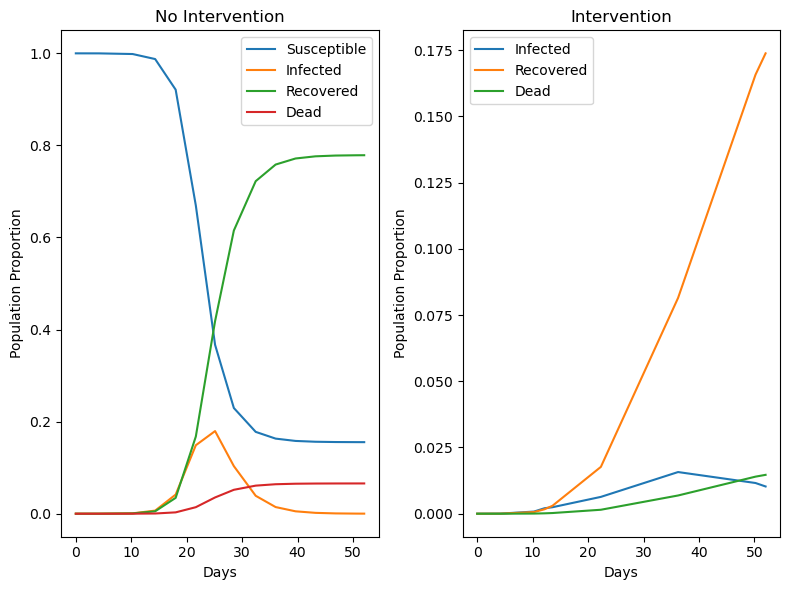

In [287]:
# Plot your results
fig, axs = plt.subplots(1, 2, figsize=(8, 6))
axs[0].plot(no_intervention.t,no_intervention.y[0],label='Susceptible')
axs[0].plot(no_intervention.t,no_intervention.y[1],label='Infected')
axs[0].plot(no_intervention.t,no_intervention.y[2],label='Recovered')
axs[0].plot(no_intervention.t,no_intervention.y[3],label='Dead')
axs[0].legend()
axs[0].set_xlabel('Days')
axs[0].set_ylabel('Population Proportion')
axs[0].set_title('No Intervention')
#axs[1].plot(full_intervention_t,full_intervention_s,label='Susceptible')
axs[1].plot(full_intervention_t,full_intervention_i,label='Infected')
axs[1].plot(full_intervention_t,full_intervention_r,label='Recovered')
axs[1].plot(full_intervention_t,full_intervention_d,label='Dead')
axs[1].legend()
axs[1].set_xlabel('Days')
axs[1].set_ylabel('Population Proportion')
axs[1].set_title('Intervention')
plt.tight_layout()
plt.show()


For more information on how the solve_ivp function works, see:
    
https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

# Problem 2: The Random Walk

Many animals perform random walks to forage for food. This has been very well characterized for _E. coli_, but it turns out other animals like C. elegans (and even humans!) essentially do the same thing. There are two steps to a random walk:

1. A run/walk/crawl: This is the time the animal is moving. We're going to assume our animals move with a constant velocity.
2. Tumble/reorientation: This is when the animal stops running, and randomly orients in a new direction.

For a random walk, the tumble can be in any direction; there is no bias. However, the length of time a run lasts tend to follow an exponential distribution. This is because animals tend to tumble/reorient at a characteristic rate (Poisson process!).

Since:

<div>
<img src="http://www.gordus.org/public_images/Lab3_1.png" width="700" style="margin-left:auto; margin-right:auto"/>
</div>

And:

<div>
<img src="http://www.gordus.org/public_images/Lab3_2.png" width="700" style="margin-left:auto; margin-right:auto"/>
</div>

We can choose a random number _r_ :

<div>
<img src="http://www.gordus.org/public_images/Lab3_3.png" width="700" style="margin-left:auto; margin-right:auto"/>
</div>

This random number represents the _P(run period > time)_. We can this use this randomly drawn number to calculate how long this run took by rearranging the equation above:

<div>
<img src="http://www.gordus.org/public_images/Lab3_4.png" width="300" style="margin-left:auto; margin-right:auto"/>
</div>

Since the animals travel at a constant speed:
<div>
<img src="http://www.gordus.org/public_images/Lab3_5.png" width="700" style="margin-left:auto; margin-right:auto"/>
</div>

## Step 1: Write a function that performs a random walk in 2D with run lengths that are exponentially distributed 

**Notes**

1. To draw a random number in the range [0,1]: `random_float = random.random()`.
2. Use Cartesian coordinates. Record where your animal is every time they reorient by recording their [x,y] coordinate.
3. Each step in the x or y direction should be randomly positive or negative. That means after you randomly draw a run length along each axis, you'll need to decide whether it's in the positive or negative direction. One way you can do this is to draw a random number between 0 and 1. If that number is less than 0.5, you go in the negative direction. If it's greater than 0.5, you go in the positive direction.

### In the cell below, write a random walk function. For each step, you should do the following for each x and y coordinate:

1. Draw a random number from 0 to 1.
2. Use this number to define a step length using the equations above.
3. Draw a second random number from 0 to 1.
4. Use this number to determine whether you should take a step in the negative direction or positive direction.

**Remember:** These steps should be **ADDED** to the prior coordinate. You want to record where each animal is after every step.

## <font color='red'>Student Input Cell: 10 points</font> 

In [ ]:
# Random walk function

# We will assume the animal's speed is 1 distance unit per time unit. i.e. disance value = time value.

# start: The starting coordinates of your animal.
# rate: The reorientation rate.
# steps: The number of steps taken.


def random_walk(start,rate,steps):
    speed = 1
    x_coords = [start[0]]
    y_coords = [start[1]]
    for step in range(steps):
        x_coords.append(np.random.choice([x_coords[step] + speed*np.log(np.random.random())/rate, x_coords[step] - speed*np.log(np.random.random())/rate]))
        y_coords.append(np.random.choice([y_coords[step] + speed*np.log(np.random.random())/rate, y_coords[step] - speed*np.log(np.random.random())/rate]))

    walk_x_y_coords = [x_coords,y_coords]
    
    return walk_x_y_coords


def vectorized_random_walk(start,rate,steps,speed=1):
    movements = np.log(np.random.random((2,steps+1)))/rate
    directionality = np.random.choice([speed,-speed],(2,steps+1))
    movements = movements * directionality
    movements[:,0]=start

    walk_x_y_coords = np.cumsum(movements,axis=1)
    return walk_x_y_coords

## Step 2: Generate a random walk of 100 steps for 100 animals with a rate of 1.

### Now that you have your random walk function, generate a random walk of 100 steps for 100 animals. Plot the trajectory of every animal.

### NOTE: Start your trajectories at [0,0].

## <font color='red'>Student Input Cell: 10 points</font> 

120 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


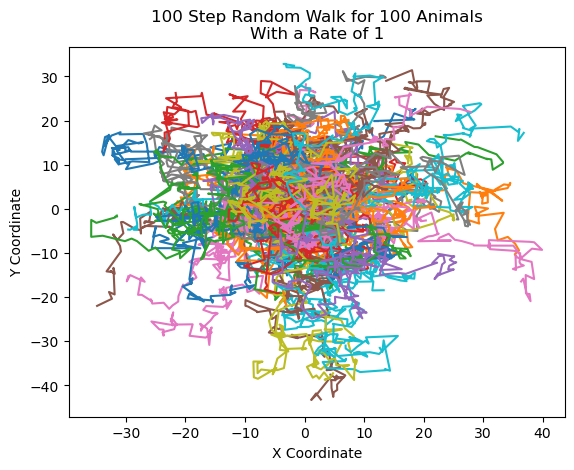

1.59 ms ± 11.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


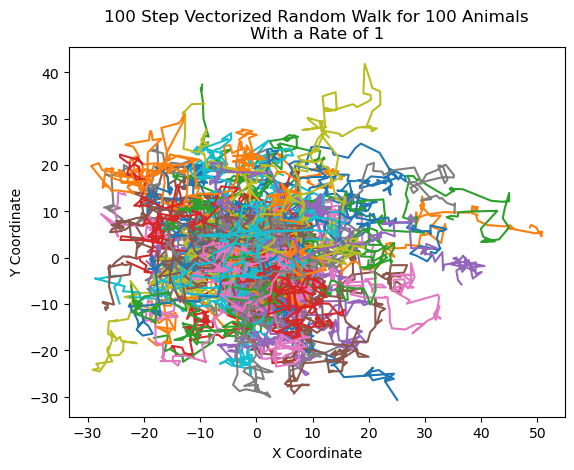

In [289]:
%timeit [random_walk((0,0),1,100) for __ in range(100)]
animals = [random_walk((0,0),1,100) for __ in range(100)]
for animal in range(len(animals)):
    plt.plot(animals[animal][0][:],animals[animal][1][:])
plt.title("100 Step Random Walk for 100 Animals\nWith a Rate of 1")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

%timeit [vectorized_random_walk((0,0),1,100) for __ in range(100)]
vectorized_animals = [vectorized_random_walk((0,0),1,100) for __ in range(100)]
for animal in range(len(vectorized_animals)):
    plt.plot(vectorized_animals[animal][0][:],vectorized_animals[animal][1][:])
plt.title("100 Step Vectorized Random Walk for 100 Animals\nWith a Rate of 1")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

## Step 3: Generate a random walk of 100 steps for 100 animals, but now do this for 3 different rates: 1, 2, 4

Plot the trajectories of the animals in different colors: rate = 1 in black, rate = 2 in blue, rate = 4 in red.

Helpful code:

If you want to plot a trace in black: `plt.plot(x,y,'k')`
If you want to plot a trace in blue: `plt.plot(x,y,'b')`
If you want to plot a trace in red: `plt.plot(x,y,'r')`

## <font color='red'>Student Input Cell: 10 points</font> 

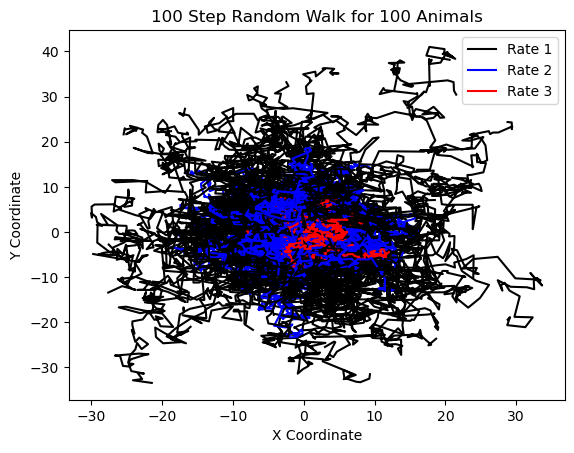

In [290]:
animals_rate_1 = [random_walk((0,0),1,100) for __ in range(100)]
animals_rate_2 = [random_walk((0,0),2,100) for __ in range(100)]
animals_rate_4 = [random_walk((0,0),4,100) for __ in range(100)]
for animal in range(len(animals_rate_1)):
    plt.plot(animals_rate_1[animal][0][:],animals_rate_1[animal][1][:],'k')
    plt.plot(animals_rate_2[animal][0][:],animals_rate_2[animal][1][:],'b')
    plt.plot(animals_rate_4[animal][0][:],animals_rate_4[animal][1][:],'r')
plt.title("100 Step Random Walk for 100 Animals")
plt.legend(["Rate 1","Rate 2","Rate 3"])
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

### What do you think? Does this make sense? If an animal reorients at a faster rate, do they also diffuse faster? Or do they diffuse more slowly?

Lower rates mean that an animal turns more often, thus it tends to remain within a smaller region and diffuse more slowly, while an animal that has a higher rate turns less often and thus tends to travel further before turning.

# Problem 3: The Biased Random Walk

Animals randomly forage for food, but they're not dumb. If they can detect a food source, they'll go toward it. However, sometimes they can detect the food source, but they don't know where it is. Ever walk around a fair, and smell food, and think "Where is that coming from?". The first thing you do is turn your head, even your body, to identify the direction of the odor. What you're doing is attempting to detect the odor **gradient**. If you turn your head to the right, and the odor intensifies, then clearly you should turn right and walk up the gradient. Conversely, if someone sets off stink-bomb, you turn **down** the gradient.

But what if you turn your head and body, and can't detect the gradient? **This is a common problem in foraging**. Oftentimes, the sensory gradient is too shallow to detect simply by moving your body locally. This is _especially_ true for small organisms, like bacteria. They are randomly bouncing around, along with the chemicals they're trying to detect, **and yet** they are still capable of diffusing up a gradient toward food! How do they do it?

They still perform a random walk, but every time they reorient they modulate their tumble rate. If the environment is improving, they **decrease** their tumble rate, and if the environment is declining, they **increase** their tumble rate. This is called **The Biased Random Walk**. They are still randomly walking around; they don't bias their direction toward the food. All they do is commit to lower reorientation rates when they detect a positive environment.

All animals appear to do this when they can't detect a sensory gradient locally. Let's try it out!

## Step 1: Make the reorientation rate a function of the local concentration.

### We are going to have the reorientation rate scale with concentration using a logistic function:
<div>
<img src="http://www.gordus.org/public_images/Lab3_6.png" width="700" style="margin-left:auto; margin-right:auto"/>
</div>

### Plot the local rate with a baseline rate of 1, as a function of "Concentration" ranging from -50 to 50.

## <font color='red'>Student Input Cell: 5 points</font> 

<function matplotlib.pyplot.show(close=None, block=None)>

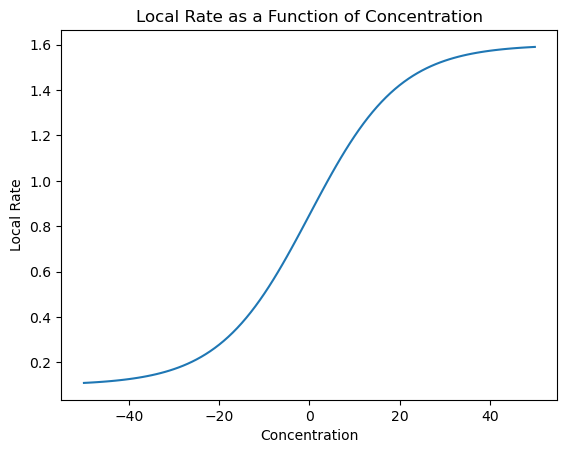

In [291]:

def local_rate(rate,concentration):
    return 1/10 + 1.5 * rate / (1+np.exp(-0.1*concentration))

plt.plot(np.arange(-50,51),[local_rate(1,concentration) for concentration in np.arange(-50,51)])
plt.title("Local Rate as a Function of Concentration")
plt.ylabel("Local Rate")
plt.xlabel("Concentration")
plt.show

### Based on this curve, how do you think the animal trajectories will be biased? Will they take longer steps at low concentrations or high concentrations? Think about this before you test this in the next section.

Animals tend to take longer steps are high concentrations, meaning they will tend to move away from regions of high concentration and linger in areas of low concentration.


## Step 2: Make a BIASED random walk function.

### This function will be VERY SIMILAR to the function you wrote earlier, except now the reorientation rate will be modulated based on the local concentration. An additional input for this function will be a concentration gradient along x.

We will define `Concentration` along x as: `Concentration = gradient * current_x`.


## <font color='red'>Student Input Cell: 10 points</font> 

In [292]:
# Biased Random walk function

# We will assume the animal's speed is 1 distance unit per time unit. i.e. disance value = time value.

# start: The starting coordinates of your animal.
# rate: The reorientation rate.
# steps: The number of steps taken.
# gradient: Concentration gradient along x.


def biased_random_walk(start,rate,steps,gradient):
    speed = 1
    x_coords = [start[0]]
    y_coords = [start[1]]
    for step in range(steps):
        x_coords.append(np.random.choice([x_coords[step] + speed*np.log(np.random.random())/local_rate(rate,gradient*x_coords[step]), x_coords[step] - speed*np.log(np.random.random())/local_rate(rate,gradient*x_coords[step])]))
        y_coords.append(np.random.choice([y_coords[step] + speed*np.log(np.random.random())/local_rate(rate,gradient*x_coords[step]), y_coords[step] - speed*np.log(np.random.random())/local_rate(rate,gradient*x_coords[step])]))

    walk_x_y_coords = [x_coords,y_coords]
    
    return walk_x_y_coords


def vectorized_biased_random_walk(start,rate,steps,gradient,speed=1):
    walk_x_y_coords = np.zeros((2,steps+1))
    walk_x_y_coords[:,0] = start
    movements = np.log(np.random.random((2,steps+1)))
    directionality = np.random.choice([speed,-speed],(2,steps+1))
    for step in range(steps):
        walk_x_y_coords[0,step+1] = walk_x_y_coords[0,step] + directionality[0,step]*movements[0,step]/local_rate(rate,gradient*walk_x_y_coords[0,step])
        walk_x_y_coords[1,step+1] = walk_x_y_coords[1,step] + directionality[1,step]*movements[1,step]/local_rate(rate,gradient*walk_x_y_coords[0,step])
    return walk_x_y_coords

## Step 3: Generate a random walk of 100 steps for 100 animals with a rate = 1 and gradient = 1.

### Plot the trajectory of every animal.

## <font color='red'>Student Input Cell: 10 points</font> 

150 ms ± 1.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


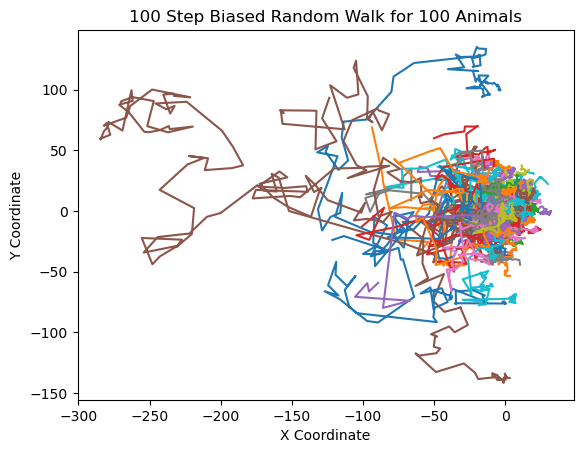

25.7 ms ± 1.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


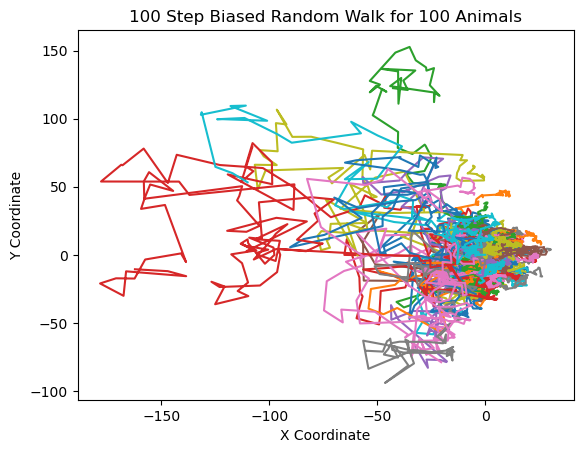

In [293]:
%timeit [biased_random_walk((0,0),1,100,1) for __ in range(100)]
biased_animals = [biased_random_walk((0,0),1,100,1) for __ in range(100)]
for animal in biased_animals:
    plt.plot(animal[0][:],animal[1][:])
plt.title("100 Step Biased Random Walk for 100 Animals")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

%timeit [vectorized_biased_random_walk((0,0),1,100,1) for __ in range(100)]
vectorized_biased_animals = [vectorized_biased_random_walk((0,0),1,100,1) for __ in range(100)]
for animal in vectorized_biased_animals:
    plt.plot(animal[0][:],animal[1][:])
plt.title("100 Step Biased Random Walk for 100 Animals")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

## What do you think? Do the trajectories look biased? 

The trajectories appear to be biased away from the positive X direction.


## Step 4: Plot 100 animals who are performing a random walk with rate = 1 (in black), and 100 animals who are performing a BIASED random walk with rate = 1 and gradient = 1 (in red).

## <font color='red'>Student Input Cell: 10 points</font> 

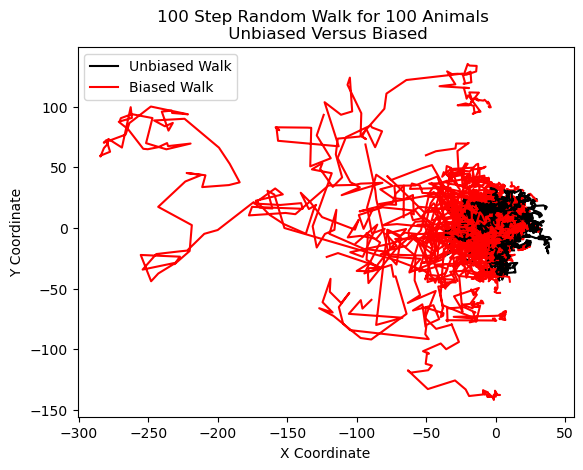

In [294]:
for animal in range(len(animals)):
    plt.plot(animals[animal][0][:],animals[animal][1][:],'k')
    plt.plot(biased_animals[animal][0][:],biased_animals[animal][1][:],'r')
plt.title("100 Step Random Walk for 100 Animals \n Unbiased Versus Biased")
plt.legend(["Unbiased Walk","Biased Walk"])
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()